<a href="https://colab.research.google.com/github/bbcndoro/bigData/blob/kris/PysparkDatasetBesar_praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
# pyspark_kaggle_nojson.py

import os
import zipfile

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, max as spark_max, min as spark_min


#
# ============================
# 1. KONFIGURASI PENGGUNA
# ============================
#

# >>>>> ISI DI SINI SESUAI AKUN KAMU <<<<<
KAGGLE_USERNAME = "masyadi"   # contoh: "djmujnusbank"
KAGGLE_KEY      = "KGAT_23c2e9a32f90ad34beaffaf8eb5c25f1"   # contoh: "a1b2c3d4....."

# Nama dataset Kaggle, format: 'author/dataset-name'
# cek di URL kaggle: https://www.kaggle.com/datasets/author/dataset-name
KAGGLE_DATASET = "zynicide/wine-reviews"   # GANTI sesuai dataset kamu

# Folder lokal tempat menyimpan hasil download
LOCAL_DATA_DIR = "./kaggle_data"

# Nama file utama di dalam zip (cek di kaggle setelah download/manual dulu jika perlu)
DATA_FILE_NAME = "winemag-data-130k-v2.csv"   # GANTI sesuai nama file dataset

# Kolom numerik & kategorikal untuk analisis
NUMERIC_COL  = "points"     # contoh numeric column
CATEGORY_COL = "country"    # contoh categorical column


In [75]:
# ============================
# 2. HELPER: SET ENV KAGGLE
# ============================

def setup_kaggle_env(username: str, key: str):
    """
    Men-setup environment variable Kaggle.
    Metode ini menghindari error 'Could not find kaggle.json'.
    """
    if not username or "ISI_" in username or not key or "ISI_" in key:
        raise ValueError(
            "KAGGLE_USERNAME dan KAGGLE_KEY belum diisi.\n"
            "Silakan buka file ini dan ganti KAGGLE_USERNAME dan KAGGLE_KEY dengan milik Anda."
        )

    os.environ["KAGGLE_USERNAME"] = username
    os.environ["KAGGLE_KEY"] = key

    print("[✓] KAGGLE_USERNAME dan KAGGLE_KEY sudah di-set di environment.")


In [76]:
# ===============================
# 3. DOWNLOAD DATASET KAGGLE
# ===============================

def download_from_kaggle(dataset_name: str, download_path: str):
    """
    Download dataset Kaggle ke folder lokal menggunakan Kaggle API.
    Tidak membutuhkan kaggle.json; cukup environment variable.
    """
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
    except ImportError:
        raise ImportError(
            "Package 'kaggle' belum terinstall.\n"
            "Jalankan: pip install kaggle"
        )

    os.makedirs(download_path, exist_ok=True)

    api = KaggleApi()
    api.authenticate()   # akan membaca dari environment variable

    print(f"[*] Downloading dataset '{dataset_name}' to '{download_path}' ...")
    api.dataset_download_files(dataset_name, path=download_path, unzip=False)
    print("[✓] Download completed.")

    # Cari file .zip hasil download di dalam download_path
    zip_files = [f for f in os.listdir(download_path) if f.endswith(".zip")]
    if not zip_files:
        raise FileNotFoundError(
            "Zip file dari Kaggle tidak ditemukan di folder download.\n"
            f"Pastikan nama dataset benar: {dataset_name}"
        )

    zip_path = os.path.join(download_path, zip_files[0])
    print(f"[*] Found zip file: {zip_path}")

    # Ekstrak zip
    print("[*] Extracting zip file...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(download_path)
    print("[✓] Extraction completed.")

    return download_path


In [77]:
# Cari file .zip hasil download
import os
import zipfile

# Define variables locally to resolve NameError in this cell for standalone execution.
# In the final, correct structure, these would be arguments to a function.
# Using global variables LOCAL_DATA_DIR and KAGGLE_DATASET.
download_path = LOCAL_DATA_DIR
dataset_name = KAGGLE_DATASET

zip_files = [f for f in os.listdir(download_path) if f.endswith(".zip")]
if not zip_files:
    raise FileNotFoundError(
        "Zip file dari Kaggle tidak ditemukan di folder download.\n"
        "Pastikan nama dataset benar: "
        f"{dataset_name}"
    )

zip_path = os.path.join(download_path, zip_files[0])
print(f"[*] Found zip file: {zip_path}")

# Ekstrak zip
print("[*] Extracting zip file...")
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(download_path)
print("[✓] Extraction completed.")

# The 'return' statement is only valid inside a function.
# It is commented out for this cell to run standalone without syntax error.
# The correct approach is to integrate this code into the 'download_from_kaggle' function.
# return download_path


[*] Found zip file: ./kaggle_data/wine-reviews.zip
[*] Extracting zip file...
[✓] Extraction completed.


In [78]:
# ============================
# 4. INISIALISASI SPARK
# ============================

def create_spark(app_name: str = "KaggleBigDataAnalysis"):
    """
    Membuat SparkSession.
    """
    spark = (
        SparkSession.builder
        .appName(app_name)
        # Tambahkan konfigurasi lain (memori, shuffle, dsb) jika perlu
        .getOrCreate()
    )
    print("[✓] SparkSession created.")
    return spark


In [83]:
# ============================
# 5. LOAD DATASET DENGAN SPARK
# ============================

def load_big_csv_with_spark(spark, data_dir: str, file_name: str):
    """
    Load CSV besar menggunakan Spark.
    """

    csv_path = os.path.join(data_dir, file_name)

    if not os.path.exists(csv_path):
        raise FileNotFoundError(
            f"File CSV '{csv_path}' tidak ditemukan.\n"
            "Cek kembali DATA_FILE_NAME dan isi sesuai nama file di folder download."
        )

    print(f"[*] Loading data from: {csv_path}")

    df = (
        spark.read
            .option("header", "true")
            .option("inferSchema", "true")     # Untuk big data idealnya define schema manual
            .csv(csv_path)
    )

    print("[*] Data loaded.")
    print("[*] Schema:")
    df.printSchema()

    # Jika dataset benar-benar besar, .count() bisa lama,
    # tapi masih berguna sebagai contoh:
    row_count = df.count()
    print("[*] Row count:", row_count)
    print(f"DEBUG (load_big_csv_with_spark): df type before return: {type(df)}")
    print(f"DEBUG (load_big_csv_with_spark): df is None before return: {df is None}")

    return df


In [80]:
# ============================
# 6. ANALISIS SEDERHANA (EDA)
# ============================

def basic_eda(df, numeric_col: str, category_col: str):
    """
    Analisis deskriptif sederhana untuk dataset besar.
    """

    print("\n=== BASIC INFO ===")
    print("Jumlah baris:", df.count())
    print("Jumlah kolom:", len(df.columns))
    print("Nama kolom:", df.columns)

    # Cek apakah kolom ada
    if numeric_col not in df.columns:
        raise ValueError(f"Kolom numerik '{numeric_col}' tidak ada di dataset.")
    if category_col not in df.columns:
        raise ValueError(f"Kolom kategori '{category_col}' tidak ada di dataset.")

    # Statistik deskriptif kolom numerik
    print(f"\n=== DESCRIPTIVE STATS for numeric column '{numeric_col}' ===")
    df.select(numeric_col).describe().show()

    # Nilai max, min, rata-rata
    print(f"\n=== AGGREGATIONS for '{numeric_col}' ===")
    agg_df = df.select(
        spark_max(col(numeric_col)).alias("max_value"),
        spark_min(col(numeric_col)).alias("min_value"),
        avg(col(numeric_col)).alias("avg_value")
    )
    agg_df.show()

    # Distribusi kategori (top 10)
    print(f"\n=== TOP 10 CATEGORY COUNTS for '{category_col}' ===")
    df.groupBy(category_col) \
        .agg(count("*").alias("cnt")) \
        .orderBy(col("cnt").desc()) \
        .show(10, truncate=False)

    return agg_df


In [81]:
# ============================
# 7. VISUALISASI (MELALUI PANDAS)
# ============================

def visualize_with_matplotlib(df, numeric_col: str, category_col: str, sample_size: int = 10000):
    """
    Visualisasi sederhana.
    - Histogram untuk kolom numerik
    - Bar chart untuk kategori TOP N
    Gunakan sample/aggregate agar tidak memori-jebol.
    """
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError(
            "Package 'matplotlib' belum terinstall.\n"
            "Jalankan: pip install matplotlib"
        )

    # 7.1 Histogram kolom numerik (pakai sample)
    print(f"[+] Sampling {sample_size} rows for numeric histogram...")
    numeric_sample = (
        df.select(numeric_col)
            .dropna()
            .limit(sample_size)      # limit untuk jangan terlalu besar
            .toPandas()
    )

    plt.figure()
    numeric_sample[numeric_col].hist(bins=30)
    plt.title(f"Histogram of {numeric_col}")
    plt.xlabel(numeric_col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # 7.2 Bar chart top 10 kategori
    print("[+] Aggregating top 10 categories for bar chart...")
    top_cat_df = (
        df.groupBy(category_col)
            .agg(count("*").alias("cnt"))
            .orderBy(col("cnt").desc())
            .limit(10)
            .toPandas()
    )

    plt.figure()
    plt.bar(top_cat_df[category_col].astype(str), top_cat_df["cnt"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top 10 {category_col}")
    plt.xlabel(category_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


[✓] KAGGLE_USERNAME dan KAGGLE_KEY sudah di-set di environment.
[*] Downloading dataset 'zynicide/wine-reviews' to './kaggle_data' ...
Dataset URL: https://www.kaggle.com/datasets/zynicide/wine-reviews
[✓] Download completed.
[*] Found zip file: ./kaggle_data/wine-reviews.zip
[*] Extracting zip file...
[✓] Extraction completed.
[✓] SparkSession created.
[*] Loading data from: ./kaggle_data/winemag-data-130k-v2.csv
[*] Data loaded.
[*] Schema:
root
 |-- _c0: string (nullable = true)
 |-- country: string (nullable = true)
 |-- description: string (nullable = true)
 |-- designation: string (nullable = true)
 |-- points: string (nullable = true)
 |-- price: string (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- region_2: string (nullable = true)
 |-- taster_name: string (nullable = true)
 |-- taster_twitter_handle: string (nullable = true)
 |-- title: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (

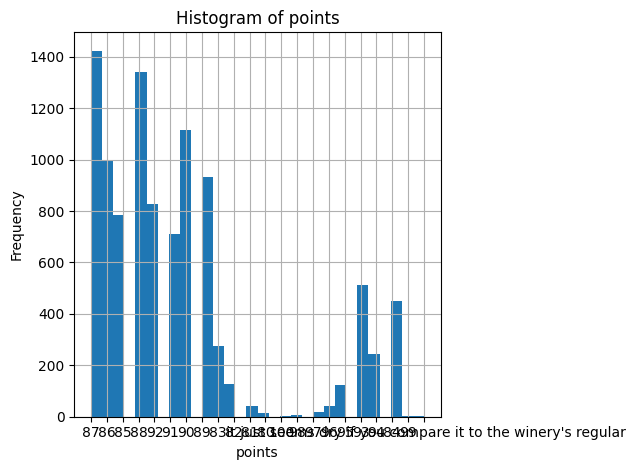

[+] Aggregating top 10 categories for bar chart...


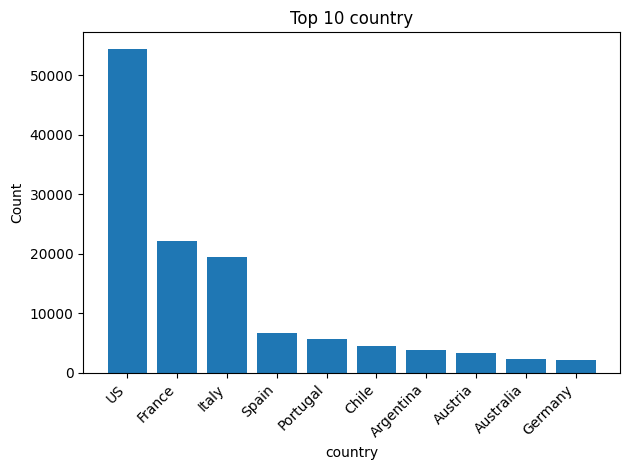

[*] Spark stopped. Selesai.


In [82]:
# ======================
# 8. MAIN
# ======================

if __name__ == "__main__":
    # 0) Setup environment Kaggle (menghindari error kaggle.json)
    setup_kaggle_env(KAGGLE_USERNAME, KAGGLE_KEY)

    # 1) Download data dari Kaggle
    data_dir = download_from_kaggle(KAGGLE_DATASET, LOCAL_DATA_DIR)

    # 2) Buat SparkSession
    spark = create_spark()

    # 3) Load data besar ke Spark DataFrame
    df = load_big_csv_with_spark(spark, data_dir, DATA_FILE_NAME)
    print(f"DEBUG (main): df type after assignment: {type(df)}")
    print(f"DEBUG (main): df is None after assignment: {df is None}")

    # 4) Analisis dasar
    basic_eda(df, NUMERIC_COL, CATEGORY_COL)

    # 5) Visualisasi (gunakan sample/aggregat)
    visualize_with_matplotlib(df, NUMERIC_COL, CATEGORY_COL, sample_size=10000)

    # 6) Stop Spark
    spark.stop()
    print("[*] Spark stopped. Selesai.")
